In [1]:
# 忽略警告信息
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import copy
import shap
import lightgbm as lgb
import sklearn.preprocessing 
import sklearn.feature_selection
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats.stats import spearmanr, pearsonr
import scipy.stats
import joblib

In [3]:
#Random seed
SEED = np.random.seed(2020)

In [4]:
############ Data Processing ###########
print("\n...... Processing Data ......\n")

#Load data
temp1_phenotype = pd.read_csv('/home/lilabguest2/shenhaoyu/GTEx_ml/mult_outlier_generater/temp1_phenotype',sep = ' ')
temp1_phenotype



...... Processing Data ......



,GTEX-indiv_id_gene_id,gene_id,indiv_id,ase_pvalue,splicing_pvalue
0,GTEX-111FC_ENSG00000000419.12,ENSG00000000419.12,111FC,NaN,0.697504
1,GTEX-111FC_ENSG00000000457.13,ENSG00000000457.13,111FC,0.569641,0.375357
2,GTEX-111FC_ENSG00000000460.16,ENSG00000000460.16,111FC,NaN,0.794816
3,GTEX-111FC_ENSG00000000938.12,ENSG00000000938.12,111FC,0.659363,0.233526
4,GTEX-111FC_ENSG00000000971.15,ENSG00000000971.15,111FC,0.599624,0.698779
...,...,...,...,...,...
7987217,GTEX-ZPU1_ENSG00000269179.1,ENSG00000269179.1,ZPU1,0.058437,NaN
7987218,GTEX-ZPU1_ENSG00000269711.1,ENSG00000269711.1,ZPU1,0.045813,NaN
7987219,GTEX-ZPU1_ENSG00000270149.5,ENSG00000270149.5,ZPU1,0.794353,NaN
7987220,GTEX-ZPU1_ENSG00000272916.5,ENSG00000272916.5,ZPU1,0.456704,NaN


In [5]:
temp1_phenotype.rename(columns={'GTEX-indiv_id_gene_id':'id'},inplace=True)
temp1_phenotype

,id,gene_id,indiv_id,ase_pvalue,splicing_pvalue
0,GTEX-111FC_ENSG00000000419.12,ENSG00000000419.12,111FC,NaN,0.697504
1,GTEX-111FC_ENSG00000000457.13,ENSG00000000457.13,111FC,0.569641,0.375357
2,GTEX-111FC_ENSG00000000460.16,ENSG00000000460.16,111FC,NaN,0.794816
3,GTEX-111FC_ENSG00000000938.12,ENSG00000000938.12,111FC,0.659363,0.233526
4,GTEX-111FC_ENSG00000000971.15,ENSG00000000971.15,111FC,0.599624,0.698779
...,...,...,...,...,...
7987217,GTEX-ZPU1_ENSG00000269179.1,ENSG00000269179.1,ZPU1,0.058437,NaN
7987218,GTEX-ZPU1_ENSG00000269711.1,ENSG00000269711.1,ZPU1,0.045813,NaN
7987219,GTEX-ZPU1_ENSG00000270149.5,ENSG00000270149.5,ZPU1,0.794353,NaN
7987220,GTEX-ZPU1_ENSG00000272916.5,ENSG00000272916.5,ZPU1,0.456704,NaN


In [6]:
#Load data
GTEx_feature_river = pd.read_csv('/home/lilabguest2/shenhaoyu/GTEx_ml/mult_outlier_generater/GTEx_feature_river.index',sep = '\t')
GTEx_feature_river


,id,SubjectID,GeneName,GC,CpG,fitCons,PHRED,DANN,phylop,GerpN,...,splice,stop,TSS__250_750_non_coding,upstream_downstream10kb_200kb,genic_plus10kb_non_coding,SNV,invDistTSS,Zscore,N2pair,Unnamed: 27
0,GTEX-111CU_ENSG00000000457.9,GTEX-111CU,ENSG00000000457.9,1.057671,1.070147,0.106686,0.854062,0.812062,1.172915,1.536639,...,0,0,0,0,1,1,-0.032098,0.133035,NaN,NaN
1,GTEX-111VG_ENSG00000000457.9,GTEX-111VG,ENSG00000000457.9,-0.295611,-0.766125,6.709830,-0.497586,-0.247452,0.401158,2.193318,...,0,0,0,0,0,1,-0.039549,0.180873,NaN,NaN
2,GTEX-111YS_ENSG00000000457.9,GTEX-111YS,ENSG00000000457.9,-0.633932,-0.503801,0.106686,-0.570891,0.352552,-0.217690,0.472576,...,0,0,0,0,1,1,-0.043518,0.266312,4.0,NaN
3,GTEX-1122O_ENSG00000000457.9,GTEX-1122O,ENSG00000000457.9,2.241793,1.594796,6.947333,0.230385,0.803394,0.238151,2.077791,...,0,0,0,0,1,1,-0.035048,-0.051501,NaN,NaN
4,GTEX-113JC_ENSG00000000457.9,GTEX-113JC,ENSG00000000457.9,-1.225993,-0.503801,-0.014524,0.995355,1.030392,0.673076,0.691469,...,0,0,0,0,1,1,-0.045419,-0.566845,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3862038,GTEX-X261_ENSG00000213077.5,GTEX-X261,ENSG00000213077.5,-0.041871,-0.503801,2.247992,1.085079,-0.093571,2.263833,-1.242086,...,0,0,0,0,1,1,-0.035131,0.249869,NaN,NaN
3862039,GTEX-XAJ8_ENSG00000213077.5,GTEX-XAJ8,ENSG00000213077.5,-0.041871,-0.503801,2.247992,1.085079,-0.093571,2.263833,-1.242086,...,0,0,0,0,1,1,-0.035131,-0.037060,NaN,NaN
3862040,GTEX-RN64_ENSG00000178115.10,GTEX-RN64,ENSG00000178115.10,1.226831,1.070147,-0.167308,-0.470067,-0.743451,0.085603,-1.175810,...,0,0,0,0,1,1,-0.040535,-0.583484,NaN,NaN
3862041,GTEX-XUZC_ENSG00000184779.8,GTEX-XUZC,ENSG00000184779.8,2.664693,4.742690,-0.308792,-0.076713,-1.185524,-0.558128,-0.691205,...,0,0,1,0,0,1,4.757583,-0.224542,NaN,NaN


In [7]:
result = pd.concat([GTEx_feature_river, temp1_phenotype], axis=1, join='inner')
result

,id,SubjectID,GeneName,GC,CpG,fitCons,PHRED,DANN,phylop,GerpN,...,SNV,invDistTSS,Zscore,N2pair,Unnamed: 27,id,gene_id,indiv_id,ase_pvalue,splicing_pvalue
0,GTEX-111CU_ENSG00000000457.9,GTEX-111CU,ENSG00000000457.9,1.057671,1.070147,0.106686,0.854062,0.812062,1.172915,1.536639,...,1,-0.032098,0.133035,NaN,NaN,GTEX-111FC_ENSG00000000419.12,ENSG00000000419.12,111FC,NaN,0.697504
1,GTEX-111VG_ENSG00000000457.9,GTEX-111VG,ENSG00000000457.9,-0.295611,-0.766125,6.709830,-0.497586,-0.247452,0.401158,2.193318,...,1,-0.039549,0.180873,NaN,NaN,GTEX-111FC_ENSG00000000457.13,ENSG00000000457.13,111FC,0.569641,0.375357
2,GTEX-111YS_ENSG00000000457.9,GTEX-111YS,ENSG00000000457.9,-0.633932,-0.503801,0.106686,-0.570891,0.352552,-0.217690,0.472576,...,1,-0.043518,0.266312,4.0,NaN,GTEX-111FC_ENSG00000000460.16,ENSG00000000460.16,111FC,NaN,0.794816
3,GTEX-1122O_ENSG00000000457.9,GTEX-1122O,ENSG00000000457.9,2.241793,1.594796,6.947333,0.230385,0.803394,0.238151,2.077791,...,1,-0.035048,-0.051501,NaN,NaN,GTEX-111FC_ENSG00000000938.12,ENSG00000000938.12,111FC,0.659363,0.233526
4,GTEX-113JC_ENSG00000000457.9,GTEX-113JC,ENSG00000000457.9,-1.225993,-0.503801,-0.014524,0.995355,1.030392,0.673076,0.691469,...,1,-0.045419,-0.566845,NaN,NaN,GTEX-111FC_ENSG00000000971.15,ENSG00000000971.15,111FC,0.599624,0.698779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3862038,GTEX-X261_ENSG00000213077.5,GTEX-X261,ENSG00000213077.5,-0.041871,-0.503801,2.247992,1.085079,-0.093571,2.263833,-1.242086,...,1,-0.035131,0.249869,NaN,NaN,GTEX-14PN3_ENSG00000170412.16,ENSG00000170412.16,14PN3,0.331627,0.503067
3862039,GTEX-XAJ8_ENSG00000213077.5,GTEX-XAJ8,ENSG00000213077.5,-0.041871,-0.503801,2.247992,1.085079,-0.093571,2.263833,-1.242086,...,1,-0.035131,-0.037060,NaN,NaN,GTEX-14PN3_ENSG00000170421.12,ENSG00000170421.12,14PN3,0.373563,0.570924
3862040,GTEX-RN64_ENSG00000178115.10,GTEX-RN64,ENSG00000178115.10,1.226831,1.070147,-0.167308,-0.470067,-0.743451,0.085603,-1.175810,...,1,-0.040535,-0.583484,NaN,NaN,GTEX-14PN3_ENSG00000170423.12,ENSG00000170423.12,14PN3,0.421552,0.717236
3862041,GTEX-XUZC_ENSG00000184779.8,GTEX-XUZC,ENSG00000184779.8,2.664693,4.742690,-0.308792,-0.076713,-1.185524,-0.558128,-0.691205,...,1,4.757583,-0.224542,NaN,NaN,GTEX-14PN3_ENSG00000170430.9,ENSG00000170430.9,14PN3,NaN,0.577331


In [8]:
result=result.drop(['gene_id','indiv_id','id','Unnamed: 27'],axis=1)
result

,SubjectID,GeneName,GC,CpG,fitCons,PHRED,DANN,phylop,GerpN,GerpS,...,stop,TSS__250_750_non_coding,upstream_downstream10kb_200kb,genic_plus10kb_non_coding,SNV,invDistTSS,Zscore,N2pair,ase_pvalue,splicing_pvalue
0,GTEX-111CU,ENSG00000000457.9,1.057671,1.070147,0.106686,0.854062,0.812062,1.172915,1.536639,1.307603,...,0,0,0,1,1,-0.032098,0.133035,NaN,NaN,0.697504
1,GTEX-111VG,ENSG00000000457.9,-0.295611,-0.766125,6.709830,-0.497586,-0.247452,0.401158,2.193318,0.636636,...,0,0,0,0,1,-0.039549,0.180873,NaN,0.569641,0.375357
2,GTEX-111YS,ENSG00000000457.9,-0.633932,-0.503801,0.106686,-0.570891,0.352552,-0.217690,0.472576,-1.093945,...,0,0,0,1,1,-0.043518,0.266312,4.0,NaN,0.794816
3,GTEX-1122O,ENSG00000000457.9,2.241793,1.594796,6.947333,0.230385,0.803394,0.238151,2.077791,1.010618,...,0,0,0,1,1,-0.035048,-0.051501,NaN,0.659363,0.233526
4,GTEX-113JC,ENSG00000000457.9,-1.225993,-0.503801,-0.014524,0.995355,1.030392,0.673076,0.691469,1.391932,...,0,0,0,1,1,-0.045419,-0.566845,NaN,0.599624,0.698779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3862038,GTEX-X261,ENSG00000213077.5,-0.041871,-0.503801,2.247992,1.085079,-0.093571,2.263833,-1.242086,0.225990,...,0,0,0,1,1,-0.035131,0.249869,NaN,0.331627,0.503067
3862039,GTEX-XAJ8,ENSG00000213077.5,-0.041871,-0.503801,2.247992,1.085079,-0.093571,2.263833,-1.242086,0.225990,...,0,0,0,1,1,-0.035131,-0.037060,NaN,0.373563,0.570924
3862040,GTEX-RN64,ENSG00000178115.10,1.226831,1.070147,-0.167308,-0.470067,-0.743451,0.085603,-1.175810,0.265955,...,0,0,0,1,1,-0.040535,-0.583484,NaN,0.421552,0.717236
3862041,GTEX-XUZC,ENSG00000184779.8,2.664693,4.742690,-0.308792,-0.076713,-1.185524,-0.558128,-0.691205,0.012601,...,0,1,0,0,1,4.757583,-0.224542,NaN,NaN,0.577331


In [9]:
result['expression_pvalue']=result['Zscore'].apply(lambda x : -scipy.stats.norm.cdf(x) if x <=0 else 1-scipy.stats.norm.cdf(x))
result

,SubjectID,GeneName,GC,CpG,fitCons,PHRED,DANN,phylop,GerpN,GerpS,...,TSS__250_750_non_coding,upstream_downstream10kb_200kb,genic_plus10kb_non_coding,SNV,invDistTSS,Zscore,N2pair,ase_pvalue,splicing_pvalue,expression_pvalue
0,GTEX-111CU,ENSG00000000457.9,1.057671,1.070147,0.106686,0.854062,0.812062,1.172915,1.536639,1.307603,...,0,0,1,1,-0.032098,0.133035,NaN,NaN,0.697504,0.447083
1,GTEX-111VG,ENSG00000000457.9,-0.295611,-0.766125,6.709830,-0.497586,-0.247452,0.401158,2.193318,0.636636,...,0,0,0,1,-0.039549,0.180873,NaN,0.569641,0.375357,0.428234
2,GTEX-111YS,ENSG00000000457.9,-0.633932,-0.503801,0.106686,-0.570891,0.352552,-0.217690,0.472576,-1.093945,...,0,0,1,1,-0.043518,0.266312,4.0,NaN,0.794816,0.394999
3,GTEX-1122O,ENSG00000000457.9,2.241793,1.594796,6.947333,0.230385,0.803394,0.238151,2.077791,1.010618,...,0,0,1,1,-0.035048,-0.051501,NaN,0.659363,0.233526,-0.479463
4,GTEX-113JC,ENSG00000000457.9,-1.225993,-0.503801,-0.014524,0.995355,1.030392,0.673076,0.691469,1.391932,...,0,0,1,1,-0.045419,-0.566845,NaN,0.599624,0.698779,-0.285410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3862038,GTEX-X261,ENSG00000213077.5,-0.041871,-0.503801,2.247992,1.085079,-0.093571,2.263833,-1.242086,0.225990,...,0,0,1,1,-0.035131,0.249869,NaN,0.331627,0.503067,0.401344
3862039,GTEX-XAJ8,ENSG00000213077.5,-0.041871,-0.503801,2.247992,1.085079,-0.093571,2.263833,-1.242086,0.225990,...,0,0,1,1,-0.035131,-0.037060,NaN,0.373563,0.570924,-0.485219
3862040,GTEX-RN64,ENSG00000178115.10,1.226831,1.070147,-0.167308,-0.470067,-0.743451,0.085603,-1.175810,0.265955,...,0,0,1,1,-0.040535,-0.583484,NaN,0.421552,0.717236,-0.279784
3862041,GTEX-XUZC,ENSG00000184779.8,2.664693,4.742690,-0.308792,-0.076713,-1.185524,-0.558128,-0.691205,0.012601,...,1,0,0,1,4.757583,-0.224542,NaN,NaN,0.577331,-0.411168


In [10]:
result=result.drop(['N2pair'],axis=1)
result

,SubjectID,GeneName,GC,CpG,fitCons,PHRED,DANN,phylop,GerpN,GerpS,...,stop,TSS__250_750_non_coding,upstream_downstream10kb_200kb,genic_plus10kb_non_coding,SNV,invDistTSS,Zscore,ase_pvalue,splicing_pvalue,expression_pvalue
0,GTEX-111CU,ENSG00000000457.9,1.057671,1.070147,0.106686,0.854062,0.812062,1.172915,1.536639,1.307603,...,0,0,0,1,1,-0.032098,0.133035,NaN,0.697504,0.447083
1,GTEX-111VG,ENSG00000000457.9,-0.295611,-0.766125,6.709830,-0.497586,-0.247452,0.401158,2.193318,0.636636,...,0,0,0,0,1,-0.039549,0.180873,0.569641,0.375357,0.428234
2,GTEX-111YS,ENSG00000000457.9,-0.633932,-0.503801,0.106686,-0.570891,0.352552,-0.217690,0.472576,-1.093945,...,0,0,0,1,1,-0.043518,0.266312,NaN,0.794816,0.394999
3,GTEX-1122O,ENSG00000000457.9,2.241793,1.594796,6.947333,0.230385,0.803394,0.238151,2.077791,1.010618,...,0,0,0,1,1,-0.035048,-0.051501,0.659363,0.233526,-0.479463
4,GTEX-113JC,ENSG00000000457.9,-1.225993,-0.503801,-0.014524,0.995355,1.030392,0.673076,0.691469,1.391932,...,0,0,0,1,1,-0.045419,-0.566845,0.599624,0.698779,-0.285410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3862038,GTEX-X261,ENSG00000213077.5,-0.041871,-0.503801,2.247992,1.085079,-0.093571,2.263833,-1.242086,0.225990,...,0,0,0,1,1,-0.035131,0.249869,0.331627,0.503067,0.401344
3862039,GTEX-XAJ8,ENSG00000213077.5,-0.041871,-0.503801,2.247992,1.085079,-0.093571,2.263833,-1.242086,0.225990,...,0,0,0,1,1,-0.035131,-0.037060,0.373563,0.570924,-0.485219
3862040,GTEX-RN64,ENSG00000178115.10,1.226831,1.070147,-0.167308,-0.470067,-0.743451,0.085603,-1.175810,0.265955,...,0,0,0,1,1,-0.040535,-0.583484,0.421552,0.717236,-0.279784
3862041,GTEX-XUZC,ENSG00000184779.8,2.664693,4.742690,-0.308792,-0.076713,-1.185524,-0.558128,-0.691205,0.012601,...,0,1,0,0,1,4.757583,-0.224542,NaN,0.577331,-0.411168


In [11]:
result=result.drop(['Zscore'],axis=1)
result

,SubjectID,GeneName,GC,CpG,fitCons,PHRED,DANN,phylop,GerpN,GerpS,...,splice,stop,TSS__250_750_non_coding,upstream_downstream10kb_200kb,genic_plus10kb_non_coding,SNV,invDistTSS,ase_pvalue,splicing_pvalue,expression_pvalue
0,GTEX-111CU,ENSG00000000457.9,1.057671,1.070147,0.106686,0.854062,0.812062,1.172915,1.536639,1.307603,...,0,0,0,0,1,1,-0.032098,NaN,0.697504,0.447083
1,GTEX-111VG,ENSG00000000457.9,-0.295611,-0.766125,6.709830,-0.497586,-0.247452,0.401158,2.193318,0.636636,...,0,0,0,0,0,1,-0.039549,0.569641,0.375357,0.428234
2,GTEX-111YS,ENSG00000000457.9,-0.633932,-0.503801,0.106686,-0.570891,0.352552,-0.217690,0.472576,-1.093945,...,0,0,0,0,1,1,-0.043518,NaN,0.794816,0.394999
3,GTEX-1122O,ENSG00000000457.9,2.241793,1.594796,6.947333,0.230385,0.803394,0.238151,2.077791,1.010618,...,0,0,0,0,1,1,-0.035048,0.659363,0.233526,-0.479463
4,GTEX-113JC,ENSG00000000457.9,-1.225993,-0.503801,-0.014524,0.995355,1.030392,0.673076,0.691469,1.391932,...,0,0,0,0,1,1,-0.045419,0.599624,0.698779,-0.285410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3862038,GTEX-X261,ENSG00000213077.5,-0.041871,-0.503801,2.247992,1.085079,-0.093571,2.263833,-1.242086,0.225990,...,0,0,0,0,1,1,-0.035131,0.331627,0.503067,0.401344
3862039,GTEX-XAJ8,ENSG00000213077.5,-0.041871,-0.503801,2.247992,1.085079,-0.093571,2.263833,-1.242086,0.225990,...,0,0,0,0,1,1,-0.035131,0.373563,0.570924,-0.485219
3862040,GTEX-RN64,ENSG00000178115.10,1.226831,1.070147,-0.167308,-0.470067,-0.743451,0.085603,-1.175810,0.265955,...,0,0,0,0,1,1,-0.040535,0.421552,0.717236,-0.279784
3862041,GTEX-XUZC,ENSG00000184779.8,2.664693,4.742690,-0.308792,-0.076713,-1.185524,-0.558128,-0.691205,0.012601,...,0,0,1,0,0,1,4.757583,NaN,0.577331,-0.411168


In [12]:
2*scipy.stats.norm.cdf(-4)

6.334248366623973e-05

In [13]:
result['eoutlier']=result['expression_pvalue'].apply(lambda x : 1 if abs(x)<=0.0013498980316300933 else 0 )#3

In [14]:
result['over_eoutlier']=result['expression_pvalue'].apply(lambda x : 1 if (x>0 and x<=0.0013498980316300933) else 0 )

In [15]:
result['under_eoutlier']=result['expression_pvalue'].apply(lambda x : 1 if (x<0 and x>=-0.0013498980316300933) else 0 )

In [16]:
result['aseoutlier']=result['ase_pvalue'].apply(lambda x : 1 if abs(x)<=1.973175290075389e-09 else 0)#6

In [17]:
result['spliceoutlier']=result['splicing_pvalue'].apply(lambda x : 1 if abs(x)<=6.334248366623973e-05 else 0)#4

In [18]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3862043 entries, 0 to 3862042
Data columns (total 32 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   SubjectID                      object 
 1   GeneName                       object 
 2   GC                             float64
 3   CpG                            float64
 4   fitCons                        float64
 5   PHRED                          float64
 6   DANN                           float64
 7   phylop                         float64
 8   GerpN                          float64
 9   GerpS                          float64
 10  TFBS                           float64
 11  EncOCpolIISig                  float64
 12  EncOCDNaseSig                  float64
 13  EncOCFaireSig                  float64
 14  EncH3K4Me3                     float64
 15  coding                         int64  
 16  frameshift                     int64  
 17  splice                         int64  
 18  st

In [19]:
result['eoutlier'].value_counts()

0    3860621
1       1422
Name: eoutlier, dtype: int64

In [20]:
result['over_eoutlier'].value_counts()

0    3861239
1        804
Name: over_eoutlier, dtype: int64

In [21]:
result['under_eoutlier'].value_counts()

0    3861456
1        587
Name: under_eoutlier, dtype: int64

In [22]:
result['aseoutlier'].value_counts()

0    3861046
1        997
Name: aseoutlier, dtype: int64

In [23]:
result['spliceoutlier'].value_counts()

0    3861440
1        603
Name: spliceoutlier, dtype: int64

In [24]:
temp=result

In [25]:
temp

,SubjectID,GeneName,GC,CpG,fitCons,PHRED,DANN,phylop,GerpN,GerpS,...,SNV,invDistTSS,ase_pvalue,splicing_pvalue,expression_pvalue,eoutlier,over_eoutlier,under_eoutlier,aseoutlier,spliceoutlier
0,GTEX-111CU,ENSG00000000457.9,1.057671,1.070147,0.106686,0.854062,0.812062,1.172915,1.536639,1.307603,...,1,-0.032098,NaN,0.697504,0.447083,0,0,0,0,0
1,GTEX-111VG,ENSG00000000457.9,-0.295611,-0.766125,6.709830,-0.497586,-0.247452,0.401158,2.193318,0.636636,...,1,-0.039549,0.569641,0.375357,0.428234,0,0,0,0,0
2,GTEX-111YS,ENSG00000000457.9,-0.633932,-0.503801,0.106686,-0.570891,0.352552,-0.217690,0.472576,-1.093945,...,1,-0.043518,NaN,0.794816,0.394999,0,0,0,0,0
3,GTEX-1122O,ENSG00000000457.9,2.241793,1.594796,6.947333,0.230385,0.803394,0.238151,2.077791,1.010618,...,1,-0.035048,0.659363,0.233526,-0.479463,0,0,0,0,0
4,GTEX-113JC,ENSG00000000457.9,-1.225993,-0.503801,-0.014524,0.995355,1.030392,0.673076,0.691469,1.391932,...,1,-0.045419,0.599624,0.698779,-0.285410,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3862038,GTEX-X261,ENSG00000213077.5,-0.041871,-0.503801,2.247992,1.085079,-0.093571,2.263833,-1.242086,0.225990,...,1,-0.035131,0.331627,0.503067,0.401344,0,0,0,0,0
3862039,GTEX-XAJ8,ENSG00000213077.5,-0.041871,-0.503801,2.247992,1.085079,-0.093571,2.263833,-1.242086,0.225990,...,1,-0.035131,0.373563,0.570924,-0.485219,0,0,0,0,0
3862040,GTEX-RN64,ENSG00000178115.10,1.226831,1.070147,-0.167308,-0.470067,-0.743451,0.085603,-1.175810,0.265955,...,1,-0.040535,0.421552,0.717236,-0.279784,0,0,0,0,0
3862041,GTEX-XUZC,ENSG00000184779.8,2.664693,4.742690,-0.308792,-0.076713,-1.185524,-0.558128,-0.691205,0.012601,...,1,4.757583,NaN,0.577331,-0.411168,0,0,0,0,0


In [26]:
temp_outlier1=temp[temp['eoutlier']==1] 
temp_outlier4=temp[temp['over_eoutlier']==1] 
temp_outlier5=temp[temp['under_eoutlier']==1] 
temp_outlier2=temp[temp['aseoutlier']==1]
temp_outlier3=temp[temp['spliceoutlier']==1]
temp_outlier = pd.concat([temp_outlier1,temp_outlier2,temp_outlier3])
temp_outlier

,SubjectID,GeneName,GC,CpG,fitCons,PHRED,DANN,phylop,GerpN,GerpS,...,SNV,invDistTSS,ase_pvalue,splicing_pvalue,expression_pvalue,eoutlier,over_eoutlier,under_eoutlier,aseoutlier,spliceoutlier
1949,GTEX-111YS,ENSG00000001461.12,0.550190,-0.503801,-0.014524,-0.307731,0.160735,0.481219,1.360309,1.098614,...,1,-0.040674,NaN,0.457718,-2.256122e-04,1,0,1,0,0
15001,GTEX-1A3MV,ENSG00000005700.10,-0.549351,-0.503801,6.947333,8.460982,1.817598,2.337763,2.442613,2.121563,...,1,-0.043352,0.999937,0.484583,-9.554704e-05,1,0,1,0,0
24445,GTEX-14XAO,ENSG00000007202.10,0.888511,0.545497,6.709830,4.136635,1.813724,1.310677,2.357488,2.018901,...,1,-0.028836,NaN,0.865194,-5.753125e-07,1,0,1,0,0
26401,GTEX-U8XE,ENSG00000007376.3,2.072633,1.070147,-0.363483,0.174191,0.398055,0.156648,0.095594,0.569540,...,1,0.000035,0.628092,0.577210,2.283937e-04,1,1,0,0,0
26926,GTEX-R55D,ENSG00000007392.12,1.226831,1.070147,0.449798,3.836012,1.468558,3.383240,2.126434,2.257223,...,1,0.067120,0.276203,0.541094,7.967656e-06,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3838852,GTEX-WYVS,ENSG00000260006.1,0.042709,-0.503801,-0.397834,-0.263562,-0.073571,0.251134,-1.151488,0.280621,...,1,-0.033210,0.323297,0.000000,-4.983344e-01,0,0,0,0,1
3850708,GTEX-T8EM,ENSG00000234745.5,0.719350,0.020848,-0.265785,-0.921695,-0.010365,0.248249,-1.132639,0.291987,...,1,-0.013795,0.003148,0.000034,4.035132e-01,0,0,0,0,1
3858501,GTEX-11LCK,ENSG00000129197.10,-0.126451,-0.766125,0.310519,-0.886777,-0.816918,0.082358,0.229362,-0.565971,...,1,-0.039213,0.553057,0.000002,-4.419200e-01,0,0,0,0,1
3860615,GTEX-17EUY,ENSG00000176222.7,1.565152,3.955717,6.149577,2.476270,1.816494,0.856999,0.928603,1.021617,...,1,0.176864,0.580957,0.000000,-4.268545e-01,0,0,0,0,1


In [27]:
#取差集(从temp中过滤temp在temp_outlier中存在的行)：
temp = temp.append(temp_outlier)
temp = temp.append(temp_outlier)
temp_ctr = temp.drop_duplicates(subset=['SubjectID',
 'GeneName',
 'GC',
 'CpG',
 'fitCons',
 'PHRED',
 'DANN',
 'phylop',
 'GerpN',
 'GerpS',
 'TFBS',
 'EncOCpolIISig',
 'EncOCDNaseSig',
 'EncOCFaireSig',
 'EncH3K4Me3',
 'coding',
 'frameshift',
 'splice',
 'stop',
 'TSS__250_750_non_coding',
 'upstream_downstream10kb_200kb',
 'genic_plus10kb_non_coding',
 'SNV',
 'invDistTSS', 
 'ase_pvalue',
 'splicing_pvalue',
 'expression_pvalue',
 'eoutlier',
 'over_eoutlier',
 'under_eoutlier',
 'aseoutlier',
 'spliceoutlier'],keep=False)

In [28]:
temp_ctr

,SubjectID,GeneName,GC,CpG,fitCons,PHRED,DANN,phylop,GerpN,GerpS,...,SNV,invDistTSS,ase_pvalue,splicing_pvalue,expression_pvalue,eoutlier,over_eoutlier,under_eoutlier,aseoutlier,spliceoutlier
0,GTEX-111CU,ENSG00000000457.9,1.057671,1.070147,0.106686,0.854062,0.812062,1.172915,1.536639,1.307603,...,1,-0.032098,NaN,0.697504,0.447083,0,0,0,0,0
1,GTEX-111VG,ENSG00000000457.9,-0.295611,-0.766125,6.709830,-0.497586,-0.247452,0.401158,2.193318,0.636636,...,1,-0.039549,0.569641,0.375357,0.428234,0,0,0,0,0
2,GTEX-111YS,ENSG00000000457.9,-0.633932,-0.503801,0.106686,-0.570891,0.352552,-0.217690,0.472576,-1.093945,...,1,-0.043518,NaN,0.794816,0.394999,0,0,0,0,0
3,GTEX-1122O,ENSG00000000457.9,2.241793,1.594796,6.947333,0.230385,0.803394,0.238151,2.077791,1.010618,...,1,-0.035048,0.659363,0.233526,-0.479463,0,0,0,0,0
4,GTEX-113JC,ENSG00000000457.9,-1.225993,-0.503801,-0.014524,0.995355,1.030392,0.673076,0.691469,1.391932,...,1,-0.045419,0.599624,0.698779,-0.285410,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3862038,GTEX-X261,ENSG00000213077.5,-0.041871,-0.503801,2.247992,1.085079,-0.093571,2.263833,-1.242086,0.225990,...,1,-0.035131,0.331627,0.503067,0.401344,0,0,0,0,0
3862039,GTEX-XAJ8,ENSG00000213077.5,-0.041871,-0.503801,2.247992,1.085079,-0.093571,2.263833,-1.242086,0.225990,...,1,-0.035131,0.373563,0.570924,-0.485219,0,0,0,0,0
3862040,GTEX-RN64,ENSG00000178115.10,1.226831,1.070147,-0.167308,-0.470067,-0.743451,0.085603,-1.175810,0.265955,...,1,-0.040535,0.421552,0.717236,-0.279784,0,0,0,0,0
3862041,GTEX-XUZC,ENSG00000184779.8,2.664693,4.742690,-0.308792,-0.076713,-1.185524,-0.558128,-0.691205,0.012601,...,1,4.757583,NaN,0.577331,-0.411168,0,0,0,0,0


In [29]:
temp_ctr['eoutlier'].value_counts()

0    3859051
Name: eoutlier, dtype: int64

In [30]:
temp_ctr['aseoutlier'].value_counts()

0    3859051
Name: aseoutlier, dtype: int64

In [31]:
temp_ctr['spliceoutlier'].value_counts()

0    3859051
Name: spliceoutlier, dtype: int64

In [32]:
#Control samples
temp_ctr1= temp_ctr.sample(len(temp_outlier1),random_state = SEED)
temp_ctr2= temp_ctr.sample(len(temp_outlier2),random_state = SEED)
temp_ctr3= temp_ctr.sample(len(temp_outlier3),random_state = SEED)
temp_ctr4= temp_ctr.sample(len(temp_outlier4),random_state = SEED)
temp_ctr5= temp_ctr.sample(len(temp_outlier5),random_state = SEED)
temp_ctr1

,SubjectID,GeneName,GC,CpG,fitCons,PHRED,DANN,phylop,GerpN,GerpS,...,SNV,invDistTSS,ase_pvalue,splicing_pvalue,expression_pvalue,eoutlier,over_eoutlier,under_eoutlier,aseoutlier,spliceoutlier
708152,GTEX-ZVZQ,ENSG00000112769.14,0.550190,-0.503801,-0.498527,-0.519785,-0.806753,-0.496099,0.946844,-0.965618,...,1,-0.046092,0.558652,NaN,0.375819,0,0,0,0,0
3027647,GTEX-1EWIQ,ENSG00000123983.9,0.381030,-0.503801,0.106686,0.879499,1.021574,0.495284,0.271924,0.816294,...,1,-0.040084,0.147151,0.184938,-0.376933,0,0,0,0,0
512504,GTEX-18A7A,ENSG00000104549.7,0.465610,0.020848,0.010633,-0.230031,0.778327,0.192712,1.299505,0.709966,...,1,-0.029293,NaN,0.300849,-0.458886,0,0,0,0,0
1167358,GTEX-14DAQ,ENSG00000135250.12,0.888511,1.332471,6.709830,4.298509,1.786670,1.416343,1.992666,1.751248,...,1,-0.022398,0.640743,0.186248,-0.259273,0,0,0,0,0
2965784,GTEX-ZXES,ENSG00000111886.9,1.057671,0.545497,0.270189,-0.418267,-0.180638,-0.027275,0.065192,0.328652,...,1,-0.040229,0.398246,0.305883,-0.494569,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081936,GTEX-QDT8,ENSG00000132275.6,1.734312,1.594796,-0.043356,0.628595,1.334351,0.248249,-1.151488,0.280621,...,1,-0.038946,0.448824,NaN,-0.370998,0,0,0,0,0
1027428,GTEX-QV44,ENSG00000129493.10,0.634770,0.020848,0.177461,2.675144,1.170079,0.504299,1.846738,1.234274,...,1,-0.045002,NaN,0.096908,0.330241,0,0,0,0,0
1097603,GTEX-UTHO,ENSG00000132792.14,1.057671,1.332471,0.177461,2.099335,1.295839,0.839328,1.737291,1.659586,...,1,-0.023305,NaN,0.464069,0.495453,0,0,0,0,0
856087,GTEX-13FTW,ENSG00000119616.7,0.888511,1.070147,-0.397834,-0.910133,0.725820,0.061080,-1.156961,0.123328,...,1,-0.042785,0.470761,0.546211,0.318208,0,0,0,0,0


In [33]:
temp1=pd.concat([temp_outlier1,temp_ctr1]).drop(['expression_pvalue','ase_pvalue','splicing_pvalue'],axis=1)
temp2=pd.concat([temp_outlier2,temp_ctr2]).drop(['expression_pvalue','ase_pvalue','splicing_pvalue'],axis=1)
temp3=pd.concat([temp_outlier3,temp_ctr3]).drop(['expression_pvalue','ase_pvalue','splicing_pvalue'],axis=1)
temp4=pd.concat([temp_outlier4,temp_ctr4]).drop(['expression_pvalue','ase_pvalue','splicing_pvalue'],axis=1)
temp5=pd.concat([temp_outlier5,temp_ctr5]).drop(['expression_pvalue','ase_pvalue','splicing_pvalue'],axis=1)
temp1

,SubjectID,GeneName,GC,CpG,fitCons,PHRED,DANN,phylop,GerpN,GerpS,...,TSS__250_750_non_coding,upstream_downstream10kb_200kb,genic_plus10kb_non_coding,SNV,invDistTSS,eoutlier,over_eoutlier,under_eoutlier,aseoutlier,spliceoutlier
1949,GTEX-111YS,ENSG00000001461.12,0.550190,-0.503801,-0.014524,-0.307731,0.160735,0.481219,1.360309,1.098614,...,0,0,1,1,-0.040674,1,0,1,0,0
15001,GTEX-1A3MV,ENSG00000005700.10,-0.549351,-0.503801,6.947333,8.460982,1.817598,2.337763,2.442613,2.121563,...,0,0,1,1,-0.043352,1,0,1,0,0
24445,GTEX-14XAO,ENSG00000007202.10,0.888511,0.545497,6.709830,4.136635,1.813724,1.310677,2.357488,2.018901,...,0,0,0,1,-0.028836,1,0,1,0,0
26401,GTEX-U8XE,ENSG00000007376.3,2.072633,1.070147,-0.363483,0.174191,0.398055,0.156648,0.095594,0.569540,...,0,0,1,1,0.000035,1,1,0,0,0
26926,GTEX-R55D,ENSG00000007392.12,1.226831,1.070147,0.449798,3.836012,1.468558,3.383240,2.126434,2.257223,...,0,0,1,1,0.067120,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081936,GTEX-QDT8,ENSG00000132275.6,1.734312,1.594796,-0.043356,0.628595,1.334351,0.248249,-1.151488,0.280621,...,0,0,1,1,-0.038946,0,0,0,0,0
1027428,GTEX-QV44,ENSG00000129493.10,0.634770,0.020848,0.177461,2.675144,1.170079,0.504299,1.846738,1.234274,...,0,0,1,1,-0.045002,0,0,0,0,0
1097603,GTEX-UTHO,ENSG00000132792.14,1.057671,1.332471,0.177461,2.099335,1.295839,0.839328,1.737291,1.659586,...,0,0,1,1,-0.023305,0,0,0,0,0
856087,GTEX-13FTW,ENSG00000119616.7,0.888511,1.070147,-0.397834,-0.910133,0.725820,0.061080,-1.156961,0.123328,...,0,0,1,1,-0.042785,0,0,0,0,0


In [34]:
temp1 = temp1.drop_duplicates()
temp2 = temp2.drop_duplicates()
temp3= temp3.drop_duplicates()
temp4= temp4.drop_duplicates()
temp5 = temp5.drop_duplicates()
temp1

,SubjectID,GeneName,GC,CpG,fitCons,PHRED,DANN,phylop,GerpN,GerpS,...,TSS__250_750_non_coding,upstream_downstream10kb_200kb,genic_plus10kb_non_coding,SNV,invDistTSS,eoutlier,over_eoutlier,under_eoutlier,aseoutlier,spliceoutlier
1949,GTEX-111YS,ENSG00000001461.12,0.550190,-0.503801,-0.014524,-0.307731,0.160735,0.481219,1.360309,1.098614,...,0,0,1,1,-0.040674,1,0,1,0,0
15001,GTEX-1A3MV,ENSG00000005700.10,-0.549351,-0.503801,6.947333,8.460982,1.817598,2.337763,2.442613,2.121563,...,0,0,1,1,-0.043352,1,0,1,0,0
24445,GTEX-14XAO,ENSG00000007202.10,0.888511,0.545497,6.709830,4.136635,1.813724,1.310677,2.357488,2.018901,...,0,0,0,1,-0.028836,1,0,1,0,0
26401,GTEX-U8XE,ENSG00000007376.3,2.072633,1.070147,-0.363483,0.174191,0.398055,0.156648,0.095594,0.569540,...,0,0,1,1,0.000035,1,1,0,0,0
26926,GTEX-R55D,ENSG00000007392.12,1.226831,1.070147,0.449798,3.836012,1.468558,3.383240,2.126434,2.257223,...,0,0,1,1,0.067120,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081936,GTEX-QDT8,ENSG00000132275.6,1.734312,1.594796,-0.043356,0.628595,1.334351,0.248249,-1.151488,0.280621,...,0,0,1,1,-0.038946,0,0,0,0,0
1027428,GTEX-QV44,ENSG00000129493.10,0.634770,0.020848,0.177461,2.675144,1.170079,0.504299,1.846738,1.234274,...,0,0,1,1,-0.045002,0,0,0,0,0
1097603,GTEX-UTHO,ENSG00000132792.14,1.057671,1.332471,0.177461,2.099335,1.295839,0.839328,1.737291,1.659586,...,0,0,1,1,-0.023305,0,0,0,0,0
856087,GTEX-13FTW,ENSG00000119616.7,0.888511,1.070147,-0.397834,-0.910133,0.725820,0.061080,-1.156961,0.123328,...,0,0,1,1,-0.042785,0,0,0,0,0


In [35]:
temp1=temp1.reset_index(drop=True)
temp2=temp2.reset_index(drop=True)
temp3=temp3.reset_index(drop=True)
temp4=temp4.reset_index(drop=True)
temp5=temp5.reset_index(drop=True)
temp1

,SubjectID,GeneName,GC,CpG,fitCons,PHRED,DANN,phylop,GerpN,GerpS,...,TSS__250_750_non_coding,upstream_downstream10kb_200kb,genic_plus10kb_non_coding,SNV,invDistTSS,eoutlier,over_eoutlier,under_eoutlier,aseoutlier,spliceoutlier
0,GTEX-111YS,ENSG00000001461.12,0.550190,-0.503801,-0.014524,-0.307731,0.160735,0.481219,1.360309,1.098614,...,0,0,1,1,-0.040674,1,0,1,0,0
1,GTEX-1A3MV,ENSG00000005700.10,-0.549351,-0.503801,6.947333,8.460982,1.817598,2.337763,2.442613,2.121563,...,0,0,1,1,-0.043352,1,0,1,0,0
2,GTEX-14XAO,ENSG00000007202.10,0.888511,0.545497,6.709830,4.136635,1.813724,1.310677,2.357488,2.018901,...,0,0,0,1,-0.028836,1,0,1,0,0
3,GTEX-U8XE,ENSG00000007376.3,2.072633,1.070147,-0.363483,0.174191,0.398055,0.156648,0.095594,0.569540,...,0,0,1,1,0.000035,1,1,0,0,0
4,GTEX-R55D,ENSG00000007392.12,1.226831,1.070147,0.449798,3.836012,1.468558,3.383240,2.126434,2.257223,...,0,0,1,1,0.067120,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2839,GTEX-QDT8,ENSG00000132275.6,1.734312,1.594796,-0.043356,0.628595,1.334351,0.248249,-1.151488,0.280621,...,0,0,1,1,-0.038946,0,0,0,0,0
2840,GTEX-QV44,ENSG00000129493.10,0.634770,0.020848,0.177461,2.675144,1.170079,0.504299,1.846738,1.234274,...,0,0,1,1,-0.045002,0,0,0,0,0
2841,GTEX-UTHO,ENSG00000132792.14,1.057671,1.332471,0.177461,2.099335,1.295839,0.839328,1.737291,1.659586,...,0,0,1,1,-0.023305,0,0,0,0,0
2842,GTEX-13FTW,ENSG00000119616.7,0.888511,1.070147,-0.397834,-0.910133,0.725820,0.061080,-1.156961,0.123328,...,0,0,1,1,-0.042785,0,0,0,0,0


In [36]:
for i in range(len(temp1)):
    if (temp1.loc[i,'eoutlier']!=1 and temp1.loc[i,'aseoutlier']!=1 and temp1.loc[i,'spliceoutlier']!=1):
        temp1.loc[i,'outlier']=int(0)
    else:
        temp1.loc[i,'outlier']=int(1)
        

In [37]:
temp1['outlier'].value_counts()

0.0    1422
1.0    1422
Name: outlier, dtype: int64

In [38]:
temp1.to_csv('/home/lilabguest2/shenhaoyu/GTEx_ml/data/GTEx_dataset_e_outlier_thrchange', sep='\t',na_rep='NA', header=True,index=False)
temp2.to_csv('/home/lilabguest2/shenhaoyu/GTEx_ml/data/GTEx_dataset_ase_outlier_thrchange', sep='\t',na_rep='NA', header=True,index=False)
temp3.to_csv('/home/lilabguest2/shenhaoyu/GTEx_ml/data/GTEx_dataset_splice_outlier_thrchange', sep='\t',na_rep='NA', header=True,index=False)
temp4.to_csv('/home/lilabguest2/shenhaoyu/GTEx_ml/data/GTEx_dataset_over_outlier_thrchange', sep='\t',na_rep='NA', header=True,index=False)
temp5.to_csv('/home/lilabguest2/shenhaoyu/GTEx_ml/data/GTEx_dataset_under_outlier_thrchange', sep='\t',na_rep='NA', header=True,index=False)

Text(0.5, 0, 'splice')

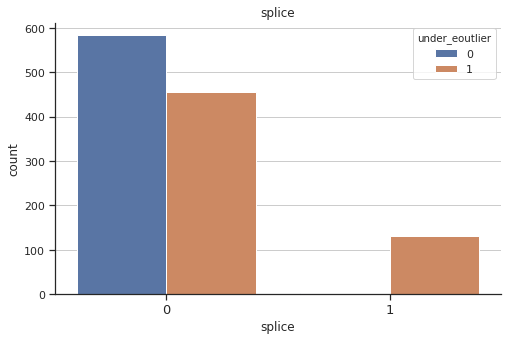

In [39]:
sn.set(style='ticks')
fig,ax=plt.subplots(figsize=(8,5))
df_3=temp5[temp5['splice'].isin(temp5['splice'].value_counts().reset_index()['index'])]
sn.countplot(df_3['splice'],hue=df_3['under_eoutlier'],data=df_3)#,palette="Set2"
for item in ['top', 'right']:
    ax.spines[item].set_visible(False) #去掉边框
ax.yaxis.grid(True,which='major')#绘制刻度线
plt.title('splice')
plt.xticks(fontsize=13)
plt.xlabel('splice')

Text(0.5, 0, 'stop')

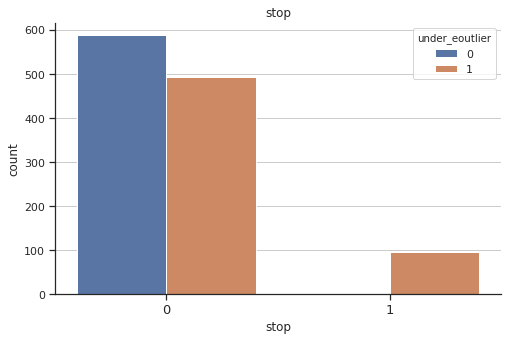

In [40]:
sn.set(style='ticks')
fig,ax=plt.subplots(figsize=(8,5))
df_3=temp5[temp5['stop'].isin(temp5['stop'].value_counts().reset_index()['index'])]
sn.countplot(df_3['stop'],hue=df_3['under_eoutlier'],data=df_3)#,palette="Set2"
for item in ['top', 'right']:
    ax.spines[item].set_visible(False) #去掉边框
ax.yaxis.grid(True,which='major')#绘制刻度线
plt.title('stop')
plt.xticks(fontsize=13)
plt.xlabel('stop')

Text(0.5, 0, 'frameshift')

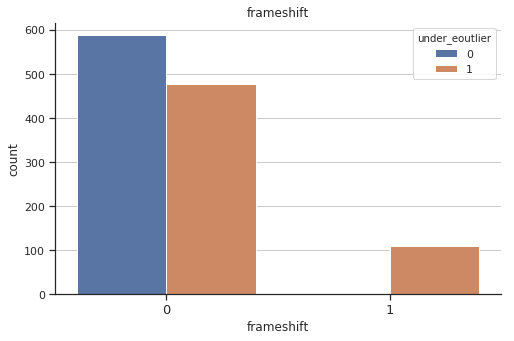

In [41]:
sn.set(style='ticks')
fig,ax=plt.subplots(figsize=(8,5))
df_3=temp5[temp5['frameshift'].isin(temp5['frameshift'].value_counts().reset_index()['index'])]
sn.countplot(df_3['frameshift'],hue=df_3['under_eoutlier'],data=df_3)#,palette="Set2"
for item in ['top', 'right']:
    ax.spines[item].set_visible(False) #去掉边框
ax.yaxis.grid(True,which='major')#绘制刻度线
plt.title('frameshift')
plt.xticks(fontsize=13)
plt.xlabel('frameshift')

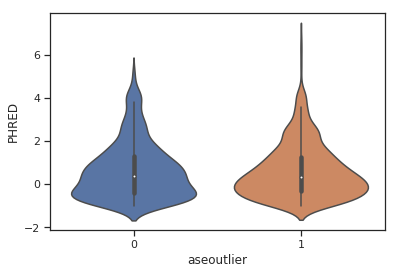

In [50]:
fig=sn.violinplot(temp2['aseoutlier'],temp2['PHRED'])
figer = fig.get_figure()
figer.savefig('/home/lilabguest2/shenhaoyu/result', dpi = 400)

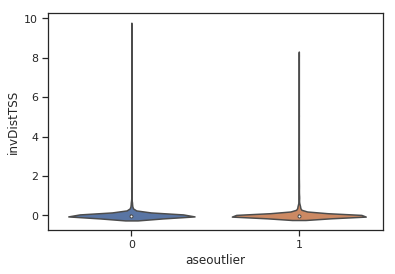

In [53]:
sn.violinplot(temp2['aseoutlier'],temp2['invDistTSS'])

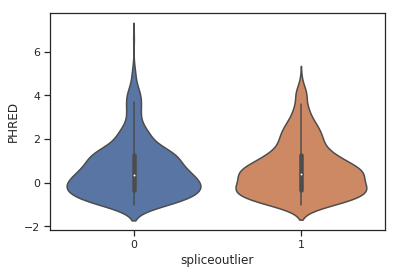

In [47]:
sn.violinplot(temp3['spliceoutlier'],temp3['PHRED'])

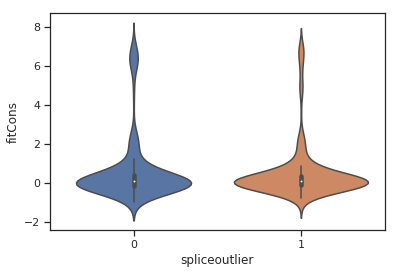

In [49]:
sn.violinplot(temp3['spliceoutlier'],temp3['fitCons'])

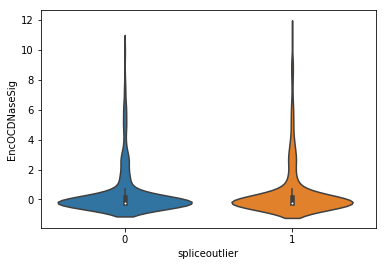

In [37]:
fig=sn.violinplot(temp3['spliceoutlier'],temp3['EncOCDNaseSig'])
figer = fig.get_figure()
figer.savefig('/home/lilabguest2/shenhaoyu/s_EncOCDNaseSig', dpi = 400)

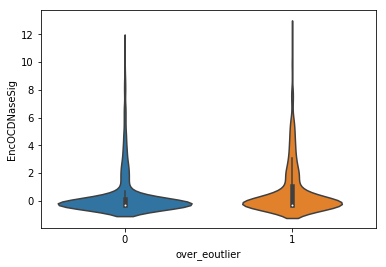

In [38]:
fig=sn.violinplot(temp4['over_eoutlier'],temp4['EncOCDNaseSig'])
figer = fig.get_figure()
figer.savefig('/home/lilabguest2/shenhaoyu/o_EncOCDNaseSig', dpi = 400)

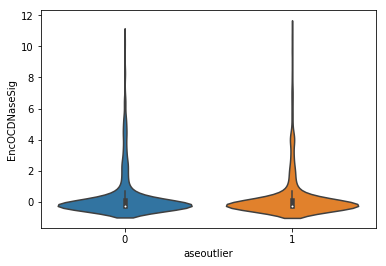

In [39]:
fig=sn.violinplot(temp2['aseoutlier'],temp2['EncOCDNaseSig'])
figer = fig.get_figure()
figer.savefig('/home/lilabguest2/shenhaoyu/a_EncOCDNaseSig', dpi = 400)

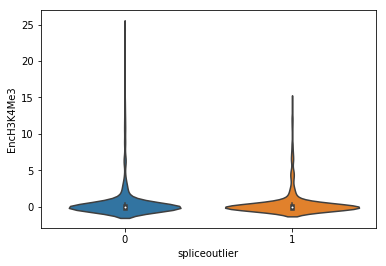

In [40]:
fig=sn.violinplot(temp3['spliceoutlier'],temp3['EncH3K4Me3'])
figer = fig.get_figure()
figer.savefig('/home/lilabguest2/shenhaoyu/s_EncH3K4Me3', dpi = 400)

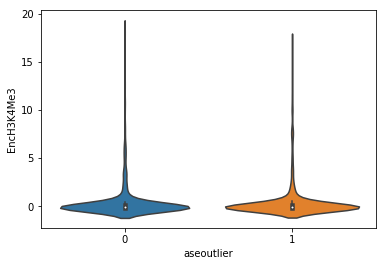

In [37]:
fig=sn.violinplot(temp2['aseoutlier'],temp2['EncH3K4Me3'])
figer = fig.get_figure()
figer.savefig('/home/lilabguest2/shenhaoyu/a_EncH3K4Me3', dpi = 400)

AttributeError: 'NoneType' object has no attribute 'savefig'

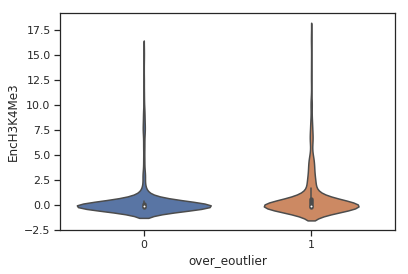

In [40]:
ig=sn.violinplot(temp4['over_eoutlier'],temp4['EncH3K4Me3'])
figer = fig.get_figure()
figer.savefig('/home/lilabguest2/shenhaoyu/o_EncH3K4Me3', dpi = 400)